In [1]:
import os
import warnings
import numpy as np
import scanpy as sc
import custom_tools
import anndata as ad
import seaborn as sns
import decoupler as dc
from pathlib import Path
from matplotlib import rcParams
import matplotlib.pyplot as plt
from dataset import TissueDataset
from pathlib import Path
import matplotlib


warnings.simplefilter(action='ignore')
sc.settings.verbosity = 0
# Set figure params
sc.set_figure_params(scanpy=True, facecolor="white", dpi=80, dpi_save=300)


In [2]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

def compare_proportions(population1, population2, cell_type='T-cell', use_fisher=False):
    """
    Compares the proportions of a specific cell type (e.g., T-cell) in two populations.

    Parameters:
    - population1: list of cell types in the first population
    - population2: list of cell types in the second population
    - cell_type: the cell type to compare (default is 'T-cell')
    - use_fisher: bool, whether to use Fisher's exact test instead of Chi-square (for smaller sample sizes)
    # teset deneme 

    Returns:
    - p-value: The p-value indicating statistical significance
    - stat_test: The type of test used ('Chi-square' or 'Fisher Exact')
    """
    # Count occurrences of the cell type in both populations
    t_cell_count1 = population1.count(cell_type)
    t_cell_count2 = population2.count(cell_type)
    print(t_cell_count1, t_cell_count2)
    
    # Get the total population sizes
    total1 = len(population1)
    total2 = len(population2)
    
    # Create a 2x2 contingency table for the proportions of T-cells vs non-T-cells
    contingency_table = [
        [t_cell_count1, total1 - t_cell_count1],  # Population 1 (T-cell vs non-T-cell)
        [t_cell_count2, total2 - t_cell_count2]   # Population 2 (T-cell vs non-T-cell)
    ]
    print(contingency_table)
    if use_fisher:
        # Use Fisher's exact test (works for small sample sizes)
        _, p_value = fisher_exact(contingency_table)
        stat_test = "Fisher Exact"
    else:
        # Use Chi-square test for larger samples
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        stat_test = "Chi-square"

    return p_value, stat_test

<h1>Loading model and dataset</h1>

In [3]:
# Read json file
# exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
# job_id = "fombnNMthdocYhDPmAjaBQ"
exp_name = "JacksonFischer"
dataset_name = "JacksonFischer"
# job_id = "2mYvWJwUarIJkw0vvUbl3Q"
job_id = "JF"
PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")



# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

# Read the explanations adata
adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/{dataset_name}/{exp_name}_{job_id}_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

# for mod in model.modules():
#    print(mod)



Seed set to 42
Seed set to 42


GPU is available on this device!
Target prediction: OSmonth


class
Immune    0.146502
Stroma    0.257709
Tumor     0.575127
Vessel    0.020662
Name: img_id, dtype: float64
class
Immune    0.156620
Stroma    0.291595
Tumor     0.524948
Vessel    0.026838
Name: img_id, dtype: float64


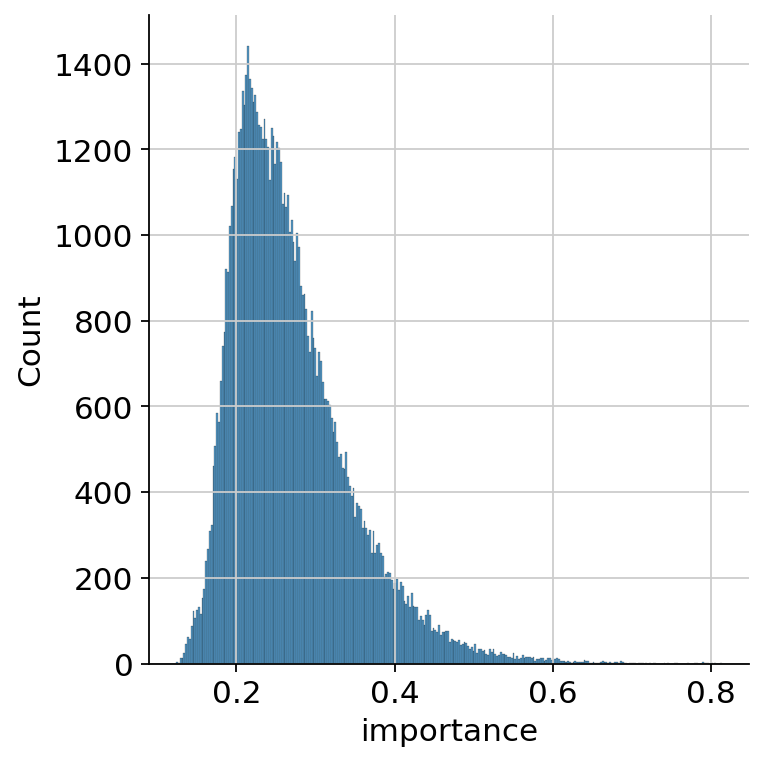

In [4]:


sns.displot(adata_exp.obs[adata_exp.obs["importance_hard"]=="True"], x="importance", bins=300)
adata_exp.obs[adata_exp.obs["importance_hard"]=="True"]


print(adata_exp.obs[adata_exp.obs["importance_hard"]=="True"].groupby("class").agg("count")["img_id"] / adata_exp.obs[adata_exp.obs["importance_hard"]=="True"].groupby("class").agg("count")["img_id"].sum())

print(adata_exp.obs.groupby("class").agg("count")["img_id"] / adata_exp.obs.groupby("class").agg("count")["img_id"].sum())


In [5]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)

In [6]:
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst= [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade.item()))
    censor_lst.append(data.is_censored[0].item())
embedding_arr.shape

(1114, 128)

In [7]:
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

In [8]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"



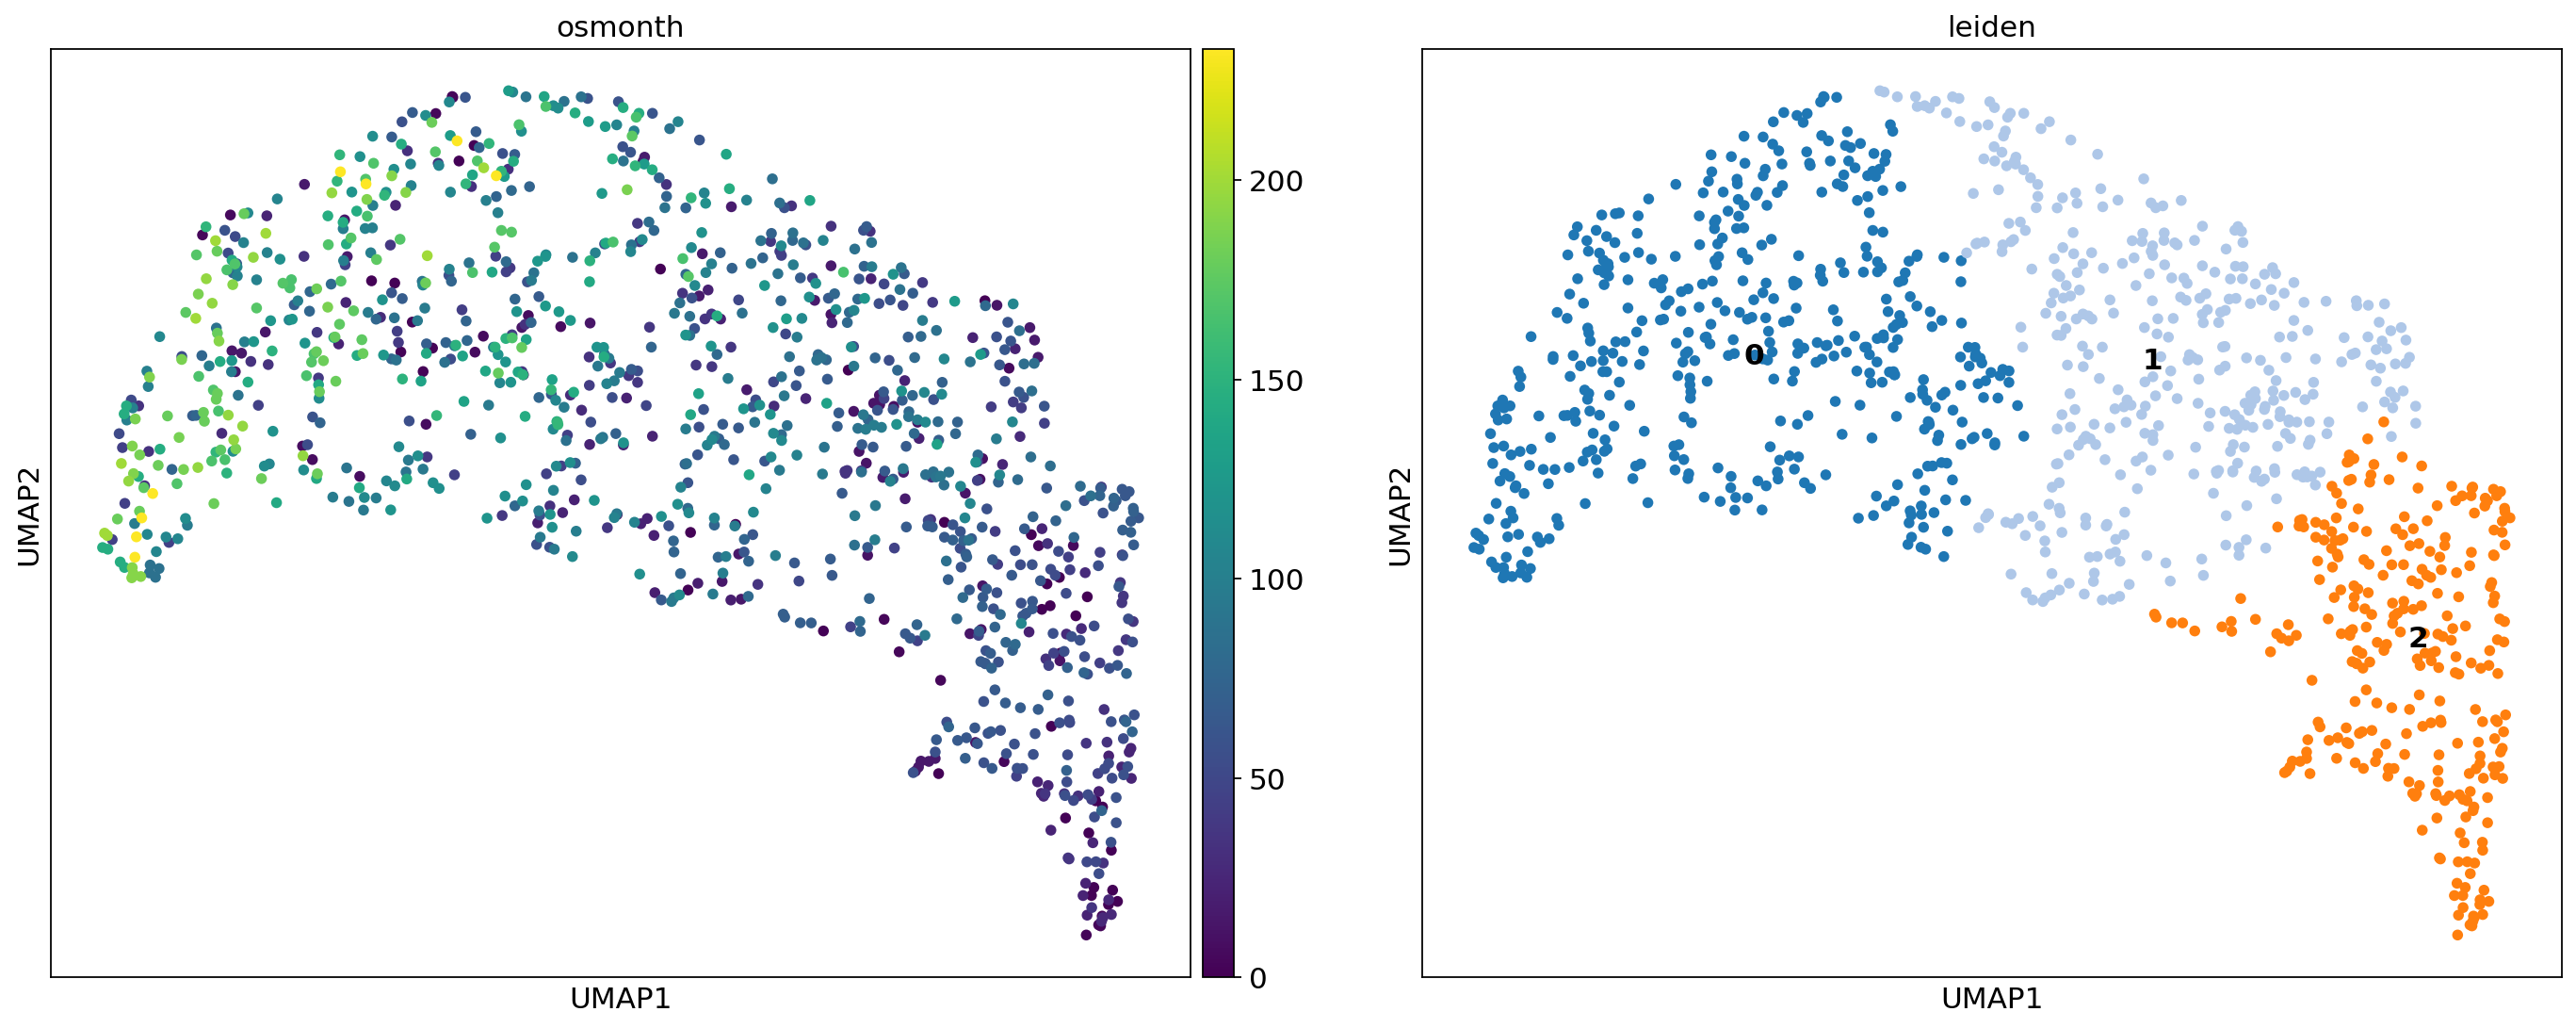

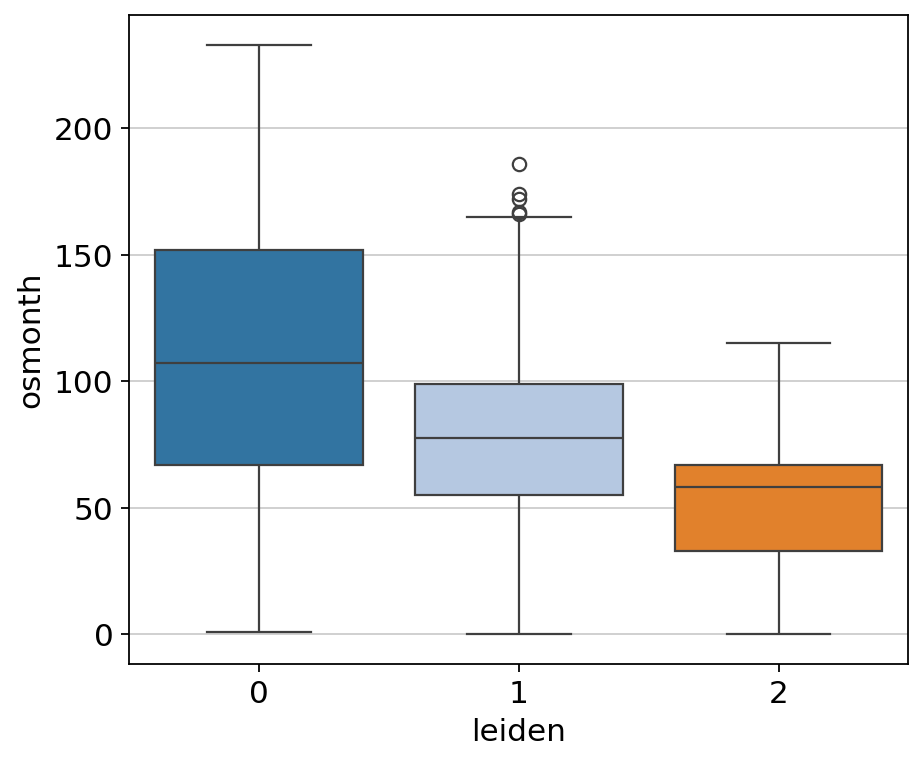

In [9]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb, color=["osmonth", "leiden"], palette=color_dict, show=False, legend_loc = 'on data') #, save="_jacksonfisher_embedding_boxplot.pdf")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_umap.pdf"), dpi=300)


fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=adata_emb.obs, x="leiden", y="osmonth", palette= color_dict)
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_boxplot.pdf"), dpi=300)
# sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
# sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
# sc.pl.umap(adata, color=["is_censored"], palette=["grey", "black"])

# sc.pl.dotplot(adata, n_genes=5, groupby='bulk_labels', dendrogram=True)

# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key=f"t-test", show=True, groupby=f"leiden")

<h2>Create Pseudobulk Profile (Important Nodes)</h2>

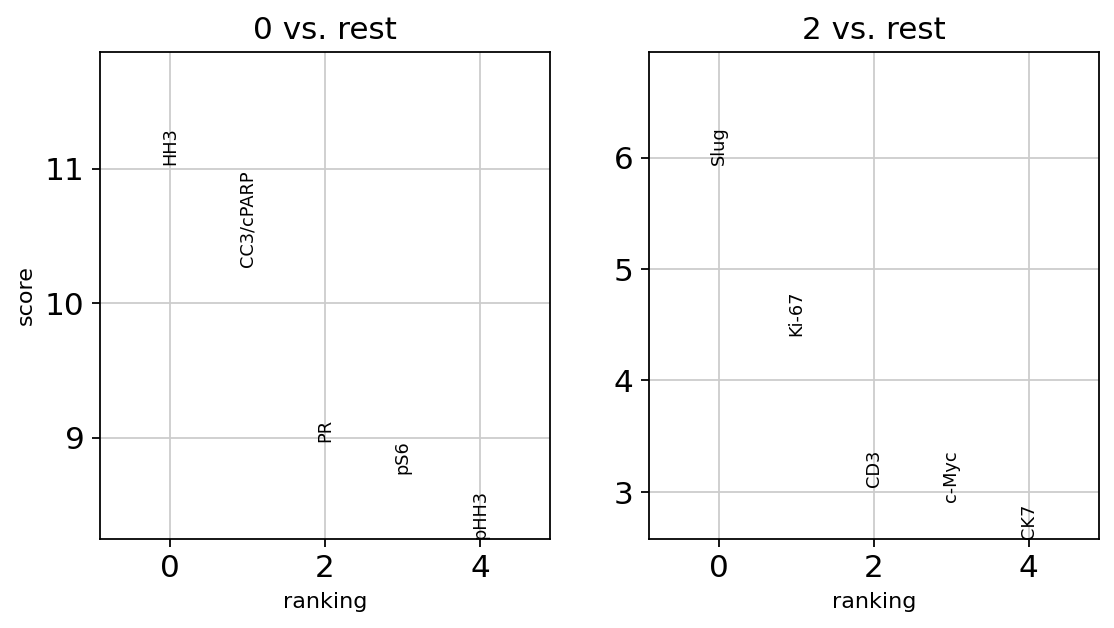

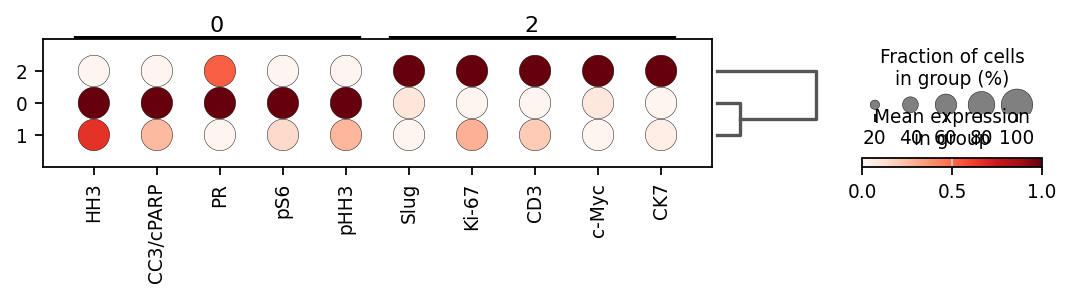

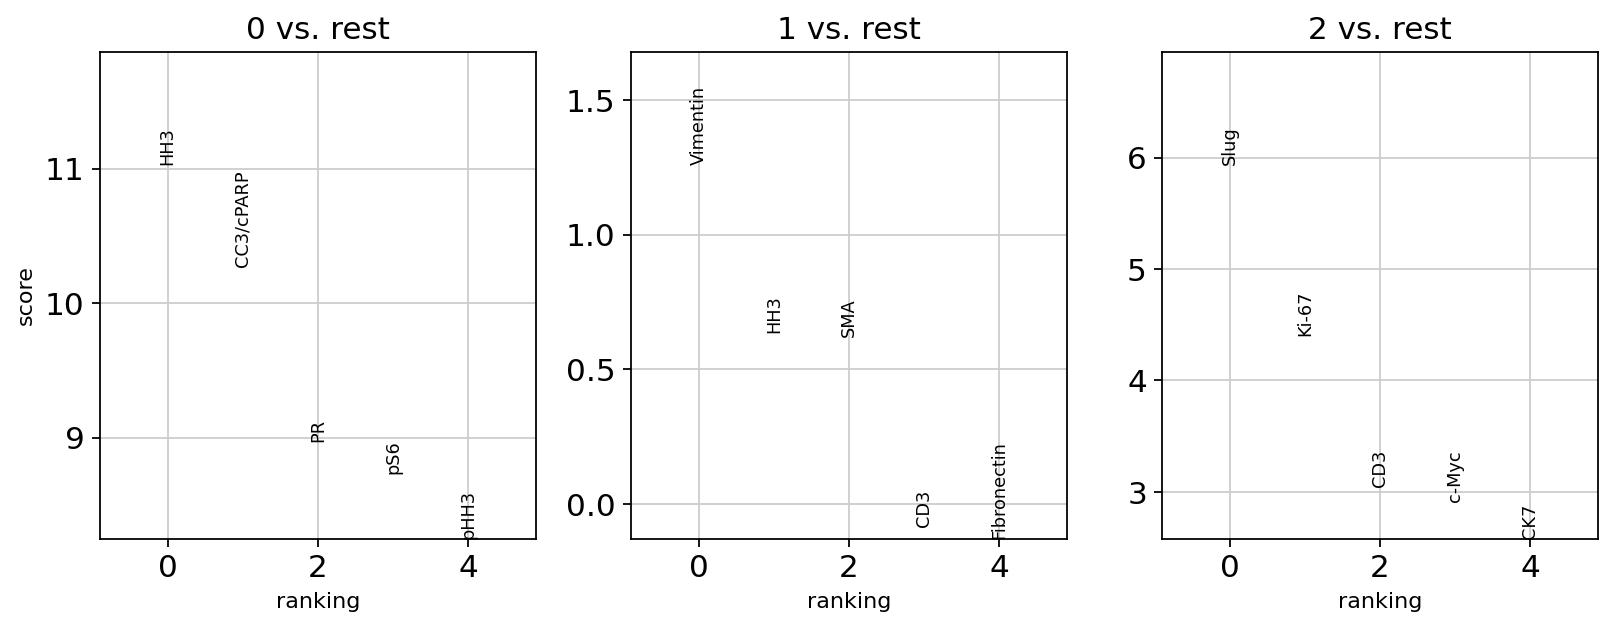

<Figure size 320x320 with 0 Axes>

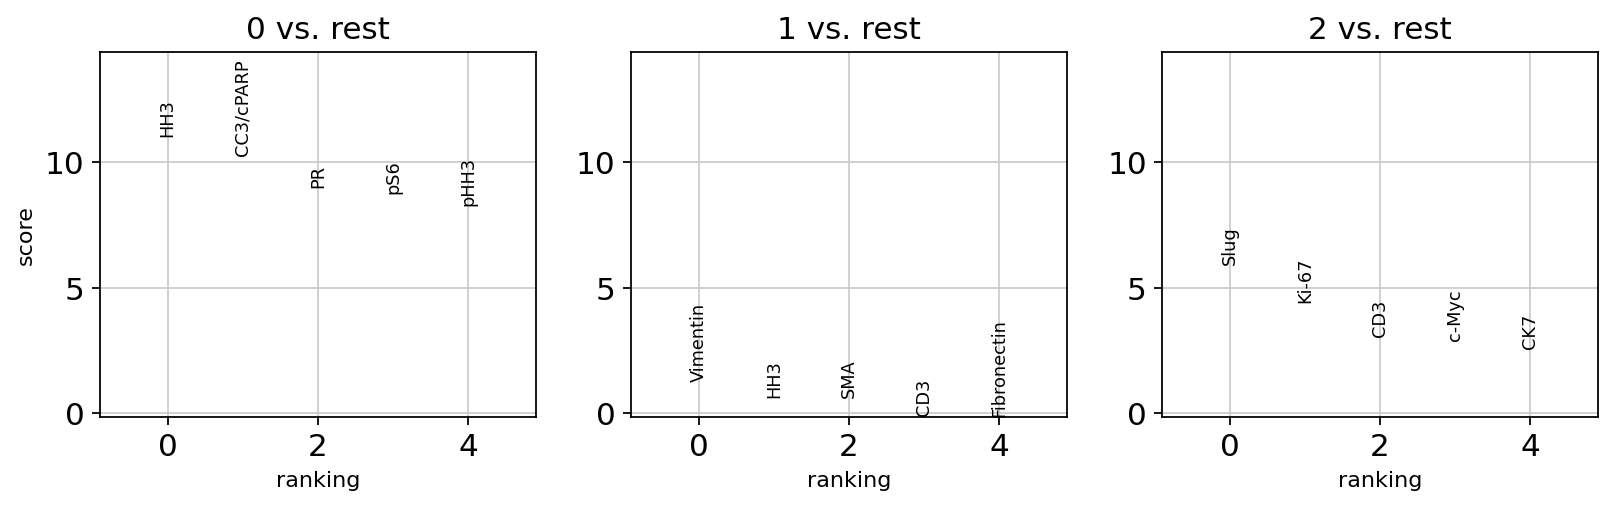

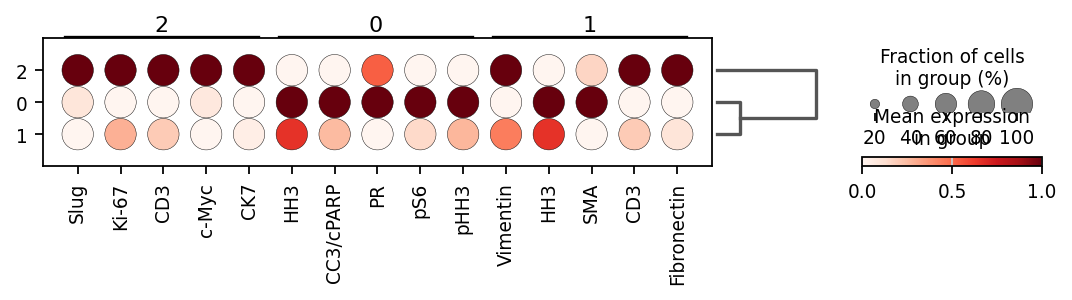

In [10]:
pdata_imp_vs_unimp = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

# create a new pseudobulk anndata with only important nodes
pdata_imp = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs_names.str.contains("True"),:].copy()
new_obs_names = [obs_n.split("_")[0] for obs_n in pdata_imp.obs_names]
pdata_imp.obs_names = new_obs_names

pdata_imp.obs["leiden"] = adata_emb.obs["leiden"]
pdata_imp.obsm["X_umap"] = adata_emb.obsm["X_umap"]

"""sc.tl.rank_genes_groups(pdata_imp, groupby=f"leiden", method='wilcoxon', groups=["0", "2"], key_added = f"wilcoxon")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 

sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon", show=False, groupby="leiden")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)

rcParams['figure.figsize']=(4,10)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot.pdf"), dpi=300)
"""




sc.tl.rank_genes_groups(pdata_imp, groupby=f"leiden", method='wilcoxon', key_added = f"wilcoxon_all")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 

sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon_all", show=True, groupby="leiden")
plt.tight_layout()
# plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)

rcParams['figure.figsize']=(4,3)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot_one_vs_all.pdf"), dpi=300)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot_one_vs_all.png"), dpi=300)

In [11]:
# TODO: Add leiden clusters to adata_exp

for cat in adata_emb.obs["leiden"].cat.categories:
    img_ids = adata_emb[adata_emb.obs["leiden"]==cat].obs["img_id"].cat.categories
    adata_exp.obs.loc[adata_exp.obs["img_id"].isin(img_ids), "leiden"] = cat

print(sorted(adata_emb[adata_emb.obs["leiden"]=="0"].obs["img_id"].cat.categories))

['100ll', '100ur', '104ll', '108ll', '108lr', '108ul', '108ur', '109ll', '109lr', '109ur', '111lr', '111ul', '111ur', '112ll', '112lr', '115ll', '115lr', '115ul', '115ur', '116ll', '116lr', '116ul', '116ur', '117ul', '118ll', '118lr', '118ul', '118ur', '121ll', '121lr', '122ur', '124ll', '124ul', '124ur', '125ul', '126ur', '127ur', '128ll', '128lr', '128ul', '128ur', '12ll', '12lr', '12ul', '12ur', '13', '132ll', '132lr', '132ul', '132ur', '136lr', '136ur', '139ll', '139ul', '141ll', '141lr', '141ul', '141ur', '144ll', '144lr', '144ul', '144ur', '145ll', '145lr', '145ul', '145ur', '147', '149ll', '149lr', '14ll', '14lr', '14ul', '14ur', '150ll', '150lr', '150ul', '150ur', '151', '152', '153', '154', '155', '159ll', '15ll', '15lr', '15ul', '15ur', '165ll', '165ul', '167ll', '167lr', '167ul', '167ur', '169ll', '169lr', '169ul', '169ur', '16ll', '16lr', '16ul', '16ur', '170', '171ll', '171lr', '171ul', '171ur', '172', '173ll', '173lr', '173ul', '173ur', '175', '176lr', '177', '178ul', '17

In [12]:
adata_exp.obs.groupby("importance_hard").agg("count")

,clinical_type,img_id,p_id,tumor_grade,osmonth,importance,cell_type,class,leiden
importance_hard,,,,,,,,,
False,758701,758701,758701,758701,758701,758701,758701,758701,758701
True,84743,84743,84743,84743,84743,84743,84743,84743,84743


In [13]:
def plot_cell_type_proportion(adata, group_col="leiden", obs_col = "cell_type", fl_path = None):
    group_list = list(adata.obs[group_col].cat.categories)
    c_type_list = list(adata.obs[obs_col].cat.categories)
    # print(len(c_type_list))
    #c_type_list.remove("Large elongated")
    #c_type_list.remove("Macrohage")
    if obs_col=="cell_type" and "Macrophage" in c_type_list:
        c_type_list.remove("Macrophage")
    print(len(c_type_list))
    c_type_list = c_type_list[:20]
    for cond in group_list:
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        for c_type in c_type_list:
            if adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]<8:
                print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
                c_type_list.remove(c_type)
            # print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
            # cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/adata_tmp.shape[0]))
    print(c_type_list)
    
    cond_prop = dict()
    cond_arr = []
    for cond in group_list:
        cond_arr.append([])
        # print(cond, cond_arr)
        cond_prop[cond] = []
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        sum = 0
        for c_type in c_type_list:


            cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/(adata_tmp[adata_tmp.obs[obs_col].isin(c_type_list),:].shape[0])))

    data = np.array(cond_arr).T
    # print("data", data.shape)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # cmap = matplotlib.cm.get_cmap('tab20')
    # print(cmap.colors)
    
    X = np.arange(data.shape[1])
    
    for i in range(data.shape[0]):
        print(data[i], c_type_list[i])
        ax1.bar(X, data[i],bottom = np.sum(data[:i], 
                    axis =0), width= 0.85, color = cmap.colors[i], label=c_type_list[i]  )

    ax1.set_xticks([0,1,2])
    ax1.set_xticklabels(group_list) # , rotation=45)
    ax1.set_xlabel("Cluster", fontweight='bold')
    ax1.set_ylabel("Proportion (%)", fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(bottom=0.45)
    fig.tight_layout()
    if fl_path:
        plt.savefig(fl_path)

    plt.show()



4
['Immune', 'Stroma', 'Tumor', 'Vessel']
[13.52304728 16.51472019 14.06028293] Immune
[25.99081073 28.0710605  22.70714194] Stroma
[59.19075145 53.55482685 59.80135013] Tumor
[1.29539054 1.85939245 3.43122501] Vessel


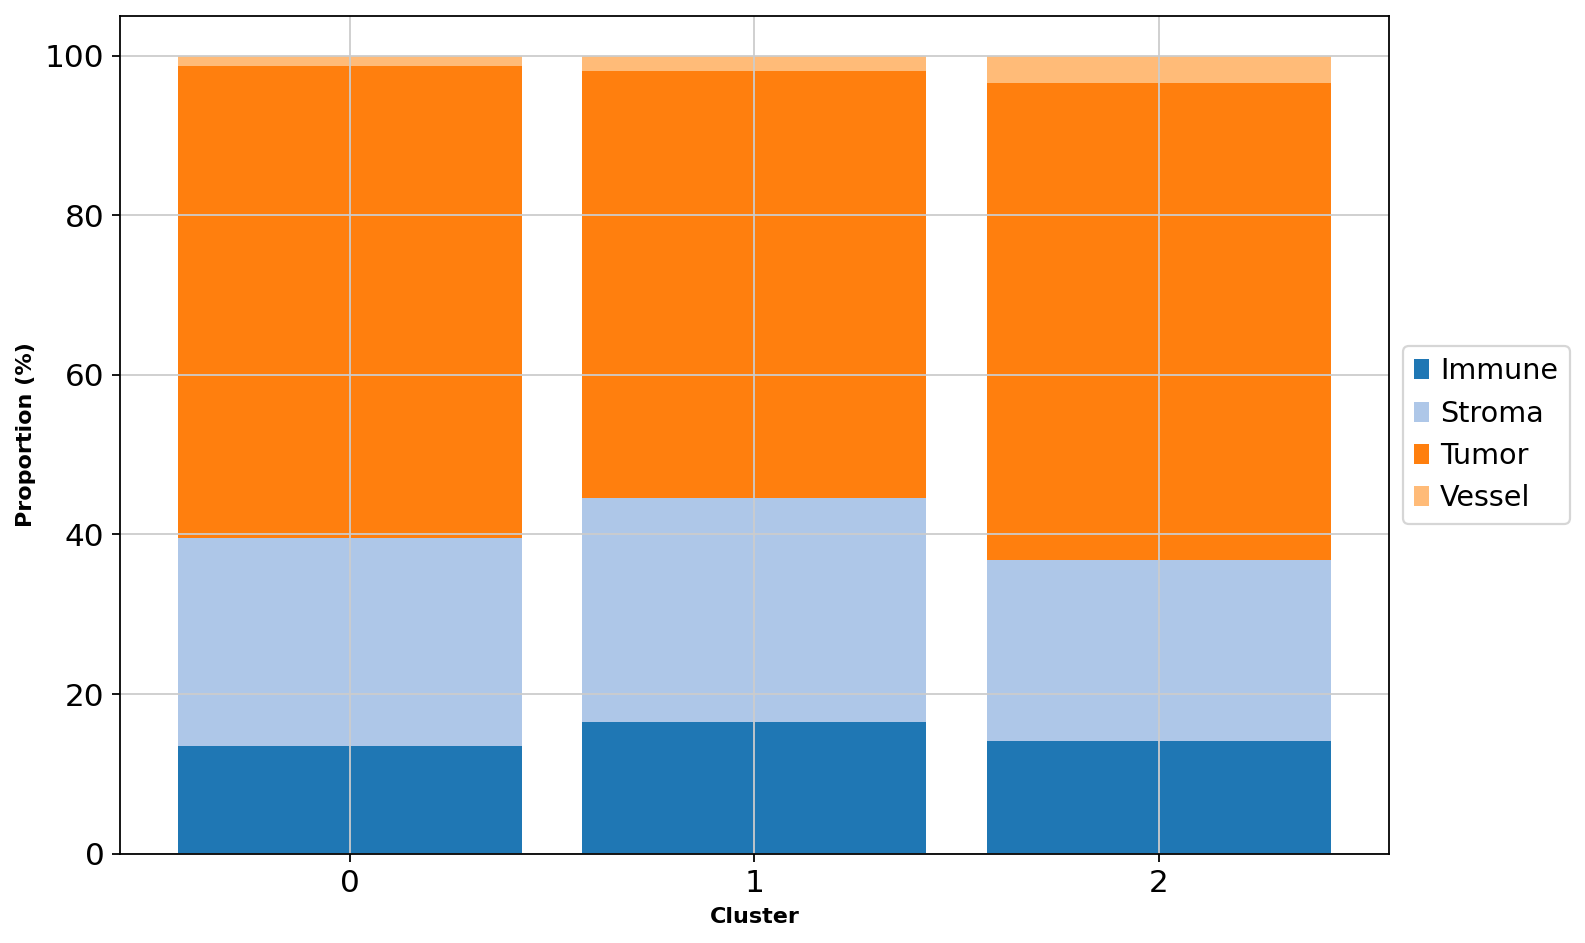

14
['Apoptotic', 'Basal CK', 'CK7+', 'CK7+ CK hi Ecadh hi', 'CK lo HR hi p53+', 'CK lo HR lo', 'CK+ HR hi', 'CK+ HR lo', 'CK+ HR+', 'Epithelial low', 'Hypoxic', 'Myoepithelial', 'Proliferative', 'p53+ EGFR+']
[4.5322516  4.42067017 4.15588151] Apoptotic
[3.78605769 4.13134168 9.10267472] Basal CK
[ 5.75921474  6.19028395 13.40954846] CK7+
[0.86137821 4.17171309 9.36870866] CK7+ CK hi Ecadh hi
[3.09995994 2.50302786 0.09347138] CK lo HR hi p53+
[16.55148237 13.08033912  6.30572332] CK lo HR lo
[17.62820513  9.30561163  3.93298821] CK+ HR hi
[17.88862179 22.68200781 10.82830026] CK+ HR lo
[10.87740385  5.3626699   3.96174863] CK+ HR+
[ 5.79427083 10.36199704  9.55565142] Epithelial low
[4.31690705 2.06567084 9.46218004] Hypoxic
[5.52884615 1.71578522 2.3511648 ] Myoepithelial
[ 2.74439103 11.29053963  8.75035951] Proliferative
[0.63100962 2.71834208 8.72159908] p53+ EGFR+


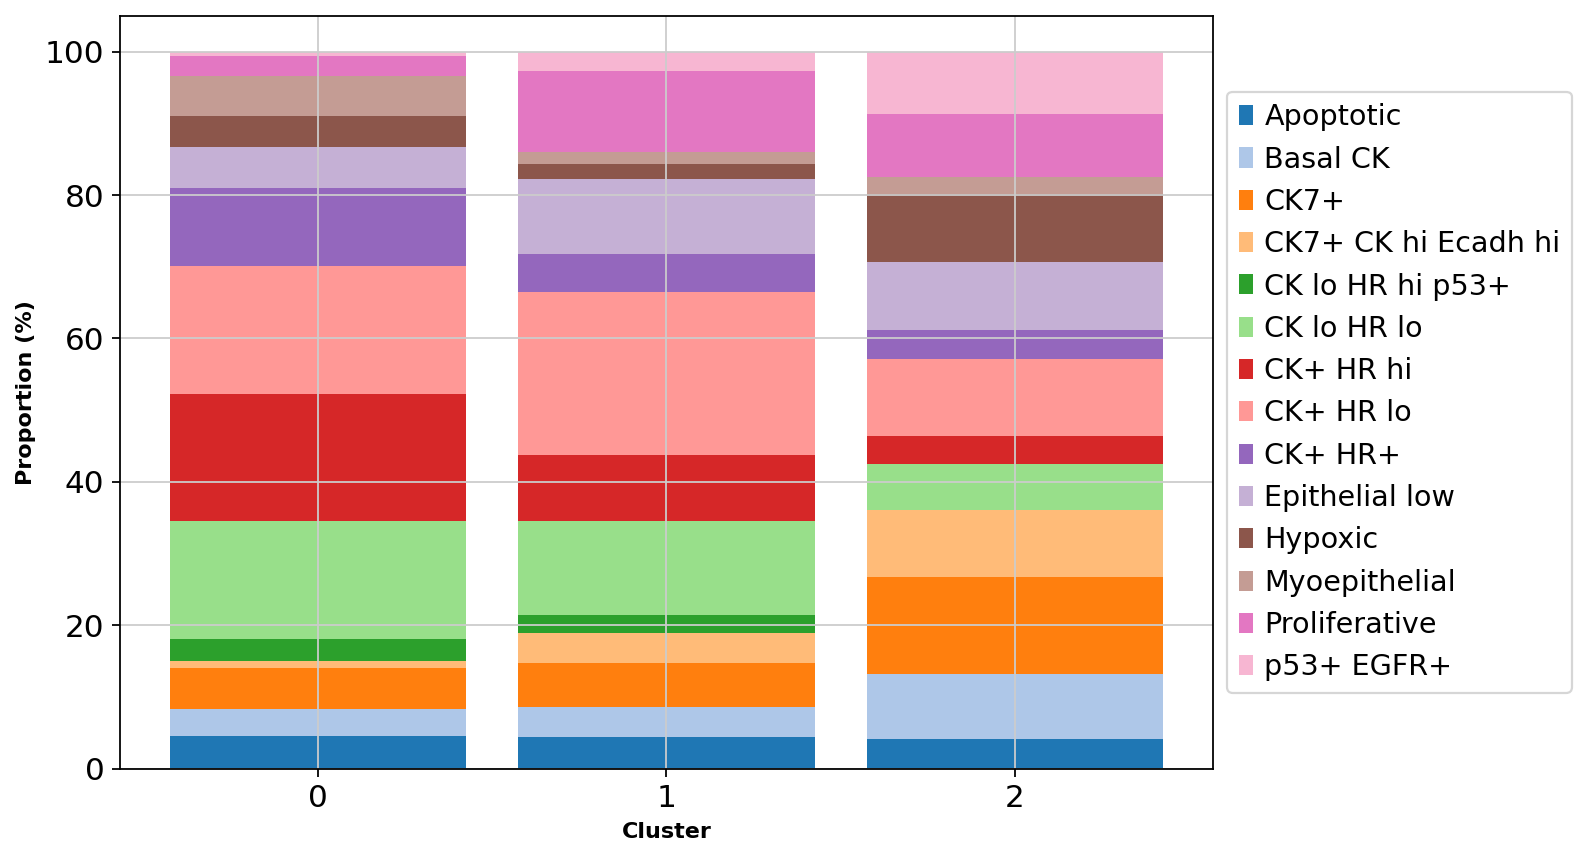

'\n# Tumor and cell type distribution\nselection = (adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Immune")\nplot_cell_type_proportion(adata_exp[selection,:], group_col="leiden", obs_col = "cell_type", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp_immune.pdf")\n\nadata_selection = adata_exp[selection,:]\n\n# print(mct, adata_exp_imp_tmp)\npopulation1 = list(adata_selection[adata_selection.obs["leiden"]=="0",:].obs["cell_type"].values)\npopulation2 = list(adata_selection[adata_selection.obs["leiden"]=="2",:].obs["cell_type"].values)\nset_cell_types = set(population1) & set(population2) \n\nns = []\nfor ct in set_cell_types:\n    p_value, test_used = compare_proportions(population1, population2, cell_type=ct)\n\n    print(f"p-value: {p_value}, Test used: {test_used}")\n\n    if p_value < 0.00001:\n        #print(f"The difference in {mct} - {ct} proportions is statistically significant.")\n        pass\n    else:\n        ns.append(ct)\n       

In [14]:
adata_exp.obs["leiden"] = adata_exp.obs["leiden"].astype("category")
# adata_exp[adata_exp.obs["importance_hard"]=="True",:]
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class")

# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class", fl_path = f"{PLT_PATH}/major_classification_prop_all.pdf")
# plot_cell_type_proportion(adata_exp[adata_exp, group_col="leiden", obs_col = "cell_type", fl_path=f"{PLT_PATH}/cell_class_prop_imp.pdf")

plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp.pdf")
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="False",:], group_col="leiden", obs_col = "class", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_notimp.pdf")
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "cell_type", fl_path=f"{PLT_PATH}/cell_class_prop_imp.pdf")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "cell_type")


# Tumor and cell type distribution
selection = (adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Tumor")
plot_cell_type_proportion(adata_exp[selection,:], group_col="leiden", obs_col = "cell_type", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp_tumor.pdf")


"""
# Tumor and cell type distribution
selection = (adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Immune")
plot_cell_type_proportion(adata_exp[selection,:], group_col="leiden", obs_col = "cell_type", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp_immune.pdf")

adata_selection = adata_exp[selection,:]

# print(mct, adata_exp_imp_tmp)
population1 = list(adata_selection[adata_selection.obs["leiden"]=="0",:].obs["cell_type"].values)
population2 = list(adata_selection[adata_selection.obs["leiden"]=="2",:].obs["cell_type"].values)
set_cell_types = set(population1) & set(population2) 

ns = []
for ct in set_cell_types:
    p_value, test_used = compare_proportions(population1, population2, cell_type=ct)

    print(f"p-value: {p_value}, Test used: {test_used}")

    if p_value < 0.00001:
        #print(f"The difference in {mct} - {ct} proportions is statistically significant.")
        pass
    else:
        ns.append(ct)
        print(f"The difference in {ct} proportions is not statistically significant.")

# plot_cell_type_proportion(adata_exp[(adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Tumor") ,:], group_col="leiden", obs_col = "cell_type", fl_path=f"{PLT_PATH}/cell_class_prop_imp.pdf")

"""


In [15]:


adata_exp_imp = adata_exp[adata_exp.obs["importance_hard"]=="True",:]
set_major_ct = set(list(adata_exp_imp.obs["class"].values)) - {"Vessel"}



# print(mct, adata_exp_imp_tmp)
population1 = list(adata_exp_imp[adata_exp_imp.obs["leiden"]=="0",:].obs["cell_type"].values)
population2 = list(adata_exp_imp[adata_exp_imp.obs["leiden"]=="2",:].obs["cell_type"].values)
set_cell_types = set(population1) & set(population2) 

ns = []
for ct in set_cell_types:
    p_value, test_used = compare_proportions(population1, population2, cell_type=ct)

    print(f"p-value: {p_value}, Test used: {test_used}")

    if p_value < 0.00001:
        #print(f"The difference in {mct} - {ct} proportions is statistically significant.")
        pass
    else:
        ns.append(ct)
        print(f"The difference in {ct} proportions is not statistically significant.")

print(ns, set_major_ct)
"""for mct in set_major_ct:
    adata_exp_imp_tmp = adata_exp[adata_exp.obs["class"]==mct,:]
    # print(mct, adata_exp_imp_tmp)
    population1 = list(adata_exp_imp_tmp[adata_exp_imp_tmp.obs["leiden"]=="0",:].obs["cell_type"].values)
    population2 = list(adata_exp_imp_tmp[adata_exp_imp_tmp.obs["leiden"]=="2",:].obs["cell_type"].values)
    set_cell_types = set(population1) & set(population2) 

    ns = []
    for ct in set_cell_types:
        print(mct, ct)
        p_value, test_used = compare_proportions(population1, population2, cell_type=ct)

        print(f"p-value: {p_value}, Test used: {test_used}")
    
        if p_value < 0.001:
            #print(f"The difference in {mct} - {ct} proportions is statistically significant.")
            pass
        else:
            ns.append(ct)
            print(f"The difference in {mct} - {ct} proportions is not statistically significant.")

    print(ns, set_major_ct)"""

236 345
[[236, 33499], [345, 22912]]
p-value: 7.99631424714647e-20, Test used: Chi-square
1104 327
[[1104, 32631], [327, 22930]]
p-value: 2.3616378549985766e-44, Test used: Chi-square
3572 1506
[[3572, 30163], [1506, 21751]]
p-value: 2.9914657413652815e-64, Test used: Chi-square
756 1266
[[756, 32979], [1266, 21991]]
p-value: 1.5931787633409388e-91, Test used: Chi-square
172 1303
[[172, 33563], [1303, 21954]]
p-value: 1.70842709297879e-309, Test used: Chi-square
170 349
[[170, 33565], [349, 22908]]
p-value: 1.3817746629047935e-34, Test used: Chi-square
862 1316
[[862, 32873], [1316, 21941]]
p-value: 3.0252206582415863e-80, Test used: Chi-square
1570 1102
[[1570, 32165], [1102, 22155]]
p-value: 0.6537868065766776, Test used: Chi-square
The difference in Small circular proportions is not statistically significant.
2164 1027
[[2164, 31571], [1027, 22230]]
p-value: 2.375703999577509e-24, Test used: Chi-square
2946 2100
[[2946, 30789], [2100, 21157]]
p-value: 0.22600069944770185, Test used:

'for mct in set_major_ct:\n    adata_exp_imp_tmp = adata_exp[adata_exp.obs["class"]==mct,:]\n    # print(mct, adata_exp_imp_tmp)\n    population1 = list(adata_exp_imp_tmp[adata_exp_imp_tmp.obs["leiden"]=="0",:].obs["cell_type"].values)\n    population2 = list(adata_exp_imp_tmp[adata_exp_imp_tmp.obs["leiden"]=="2",:].obs["cell_type"].values)\n    set_cell_types = set(population1) & set(population2) \n\n    ns = []\n    for ct in set_cell_types:\n        print(mct, ct)\n        p_value, test_used = compare_proportions(population1, population2, cell_type=ct)\n\n        print(f"p-value: {p_value}, Test used: {test_used}")\n    \n        if p_value < 0.001:\n            #print(f"The difference in {mct} - {ct} proportions is statistically significant.")\n            pass\n        else:\n            ns.append(ct)\n            print(f"The difference in {mct} - {ct} proportions is not statistically significant.")\n\n    print(ns, set_major_ct)'

Apoptotic
B cell
Basal CK
CK7+
CK7+ CK hi Ecadh hi
CK lo HR hi p53+
CK lo HR lo
CK+ HR hi
CK+ HR lo
CK+ HR+
Endothelial
Epithelial low
Fibronectin hi
Hypoxic
Large elongated
Macrohage
Macrophage
Myoepithelial
Proliferative
SMA hi Vimentin hi
Small circular
Small elongated
T & B cells
T cell
Vimentin hi
p53+ EGFR+
Performing statistical analysis for  Apoptotic
Performing statistical analysis for  B cell
Performing statistical analysis for  Basal CK
Performing statistical analysis for  CK7+
Performing statistical analysis for  CK7+ CK hi Ecadh hi
Performing statistical analysis for  CK lo HR hi p53+
Performing statistical analysis for  CK lo HR lo
Performing statistical analysis for  CK+ HR hi
Performing statistical analysis for  CK+ HR lo
Performing statistical analysis for  CK+ HR+
Performing statistical analysis for  Endothelial
Performing statistical analysis for  Epithelial low
Performing statistical analysis for  Fibronectin hi
Performing statistical analysis for  Hypoxic
Performin

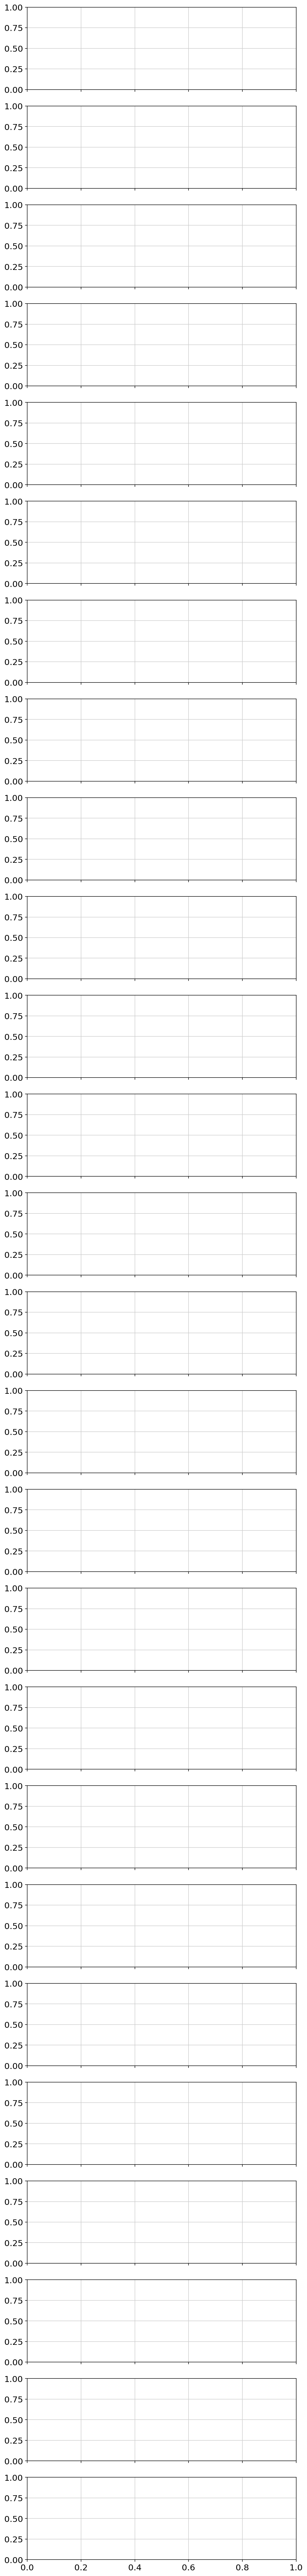

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import pickle

df = adata_exp.obs.copy()
# Number of permutations
N_PERMUTATIONS = 10000

# Filter for important cells
df_filtered = df[df["importance_hard"] == "True"]

# Compute counts and proportions
count_table = df_filtered.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
prop_table = count_table.div(count_table.sum(axis=1), axis=0)  # Normalize to proportions

    
# print(count_table)
# print(prop_table)
# Function for permutation test
def permutation_test(cluster1, cluster2, cell_type, df, n_permutations=N_PERMUTATIONS):
    # Get observed proportion difference
    observed_diff = abs(prop_table.loc[cluster1, cell_type] - prop_table.loc[cluster2, cell_type])

    # Generate null distribution
    null_diffs = []
    for _ in range(n_permutations):
        shuffled_clusters = np.random.permutation(df["leiden"])  # Shuffle cluster labels
        shuffled_counts = df.copy()
        shuffled_counts["leiden"] = shuffled_clusters
        
        # Recalculate proportions with shuffled data
        shuffled_counts = shuffled_counts.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
        shuffled_props = shuffled_counts.div(shuffled_counts.sum(axis=1), axis=0)

        # Compute new proportion difference
        null_diffs.append(abs(shuffled_props.loc[cluster1, cell_type] - shuffled_props.loc[cluster2, cell_type]))

    # Compute empirical p-value
    p_value = (np.sum(np.array(null_diffs) >= observed_diff) + 1) / (n_permutations + 1)
    return p_value

# Perform permutation test for all cell types
p_values_all = {}
posthoc_results = {}

for cell_type in prop_table.columns:
    print(cell_type)
    pairwise_p_values = []
    pairwise_comparisons = []

    # Generate pairwise comparisons for all clusters
    for cluster1, cluster2 in combinations(count_table.index, 2):
        p_value = permutation_test(cluster1, cluster2, cell_type, df_filtered, N_PERMUTATIONS)
        pairwise_p_values.append(p_value)
        pairwise_comparisons.append((cluster1, cluster2))

    # Adjust for multiple testing (FDR correction)
    _, p_adjusted, _, _ = multipletests(pairwise_p_values, method="fdr_bh")

    # Store significant results
    posthoc_results[cell_type] = {pair: p for pair, p in zip(pairwise_comparisons, p_adjusted) if p < 0.001}

# Function to convert p-values into asterisks
def pval_to_stars(p):
    if p < 0.0001:
        return "***"
    elif p < 0.001:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""    


os.makedirs(PLT_PATH, exist_ok=True)

# Plot proportions with significance markers
num_cell_types = len(prop_table.columns)
fig, axes = plt.subplots(nrows=num_cell_types, figsize=(8, num_cell_types * 3), sharex=True)

if num_cell_types == 1:
    axes = [axes]  # Ensure axes is iterable for a single plot

# prop_table
# posthoc_results
# save the edge indices and as a list 

"""with open(os.path.join(PLT_PATH, f'{dataset_name}_prop_table.pickle'), 'wb') as handle:
    pickle.dump(prop_table, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(PLT_PATH, f'{dataset_name}_posthoc_results.pickle'), 'wb') as handle:
    pickle.dump(posthoc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(PLT_PATH, f'{dataset_name}_p_values_all.pickle'), 'wb') as handle:
    pickle.dump(p_values_all, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

    

"""for ax, cell_type in zip(axes, prop_table.columns):
    print(cell_type, 2)
    # Sort clusters by proportion
    sorted_clusters = prop_table[cell_type].sort_values(ascending=False).index
    sorted_props = prop_table.loc[sorted_clusters, cell_type]

    sns.barplot(x=sorted_clusters, y=sorted_props, ax=ax, palette="viridis")
    ax.set_title(f"Proportion of {cell_type} across clusters\n(Permutation test)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Cluster")
    ax.set_ylim(0,0.2)

    # Add statistical significance markers for multiple clusters
    cluster_positions = np.arange(len(sorted_clusters))
    if cell_type in posthoc_results:
        for (cluster1, cluster2), p_val in posthoc_results[cell_type].items():
            print(p_val)
            if cluster1 in sorted_clusters and cluster2 in sorted_clusters:
                y_max = max(sorted_props[cluster1], sorted_props[cluster2]) + 0.05
                x1, x2 = cluster_positions[sorted_clusters == cluster1][0], cluster_positions[sorted_clusters == cluster2][0]

                # Add a line and asterisks
                ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], color="black")
                ax.text((x1 + x2) / 2, y_max + 0.03, pval_to_stars(p_val), ha="center", va="bottom", fontsize=12, color="red")

plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f'{dataset_name}_proportions.pdf'))
plt.savefig(os.path.join(PLT_PATH, f'{dataset_name}_proportions.png'))
plt.show()
"""

# Generate separate figures for each cell type
for cell_type in prop_table.columns:
    print("Performing statistical analysis for ", cell_type)
    fig, ax = plt.subplots(figsize=(8, 4))

    # Sort clusters by proportion
    sorted_clusters = prop_table[cell_type].sort_values(ascending=False).index
    sorted_props = prop_table.loc[sorted_clusters, cell_type]

    sns.barplot(x=sorted_clusters, y=sorted_props, ax=ax, palette="viridis")
    ax.set_title(f"Proportion of {cell_type} across clusters\n(Permutation test)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Cluster")
    ax.set_ylim(0, 0.2)

    # Add statistical significance markers
    cluster_positions = np.arange(len(sorted_clusters))
    if cell_type in posthoc_results:
        for (cluster1, cluster2), p_val in posthoc_results[cell_type].items():
            if cluster1 in sorted_clusters and cluster2 in sorted_clusters:
                y_max = max(sorted_props[cluster1], sorted_props[cluster2]) + 0.05
                x1, x2 = cluster_positions[sorted_clusters == cluster1][0], cluster_positions[sorted_clusters == cluster2][0]

                # Add line and significance stars
                ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], color="black")
                ax.text((x1 + x2) / 2, y_max + 0.03, pval_to_stars(p_val), ha="center", va="bottom", fontsize=12, color="red")

    # Save each figure separately
    plt.tight_layout()
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.pdf"))
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.png"))
    plt.close(fig)  # Close the figure to avoid memory issues

print("Figures saved successfully.")

Apoptotic
B cell
Basal CK
CK7+
CK7+ CK hi Ecadh hi
CK lo HR hi p53+
CK lo HR lo
CK+ HR hi
CK+ HR lo
CK+ HR+
Endothelial
Epithelial low
Fibronectin hi
Hypoxic
Large elongated
Macrohage
Macrophage
Myoepithelial
Proliferative
SMA hi Vimentin hi
Small circular
Small elongated
T & B cells
T cell
Vimentin hi
p53+ EGFR+
Performing statistical analysis for  Apoptotic
Performing statistical analysis for  B cell
Performing statistical analysis for  Basal CK
Performing statistical analysis for  CK7+
Performing statistical analysis for  CK7+ CK hi Ecadh hi
Performing statistical analysis for  CK lo HR hi p53+
Performing statistical analysis for  CK lo HR lo
Performing statistical analysis for  CK+ HR hi
Performing statistical analysis for  CK+ HR lo
Performing statistical analysis for  CK+ HR+
Performing statistical analysis for  Endothelial
Performing statistical analysis for  Epithelial low
Performing statistical analysis for  Fibronectin hi
Performing statistical analysis for  Hypoxic
Performin

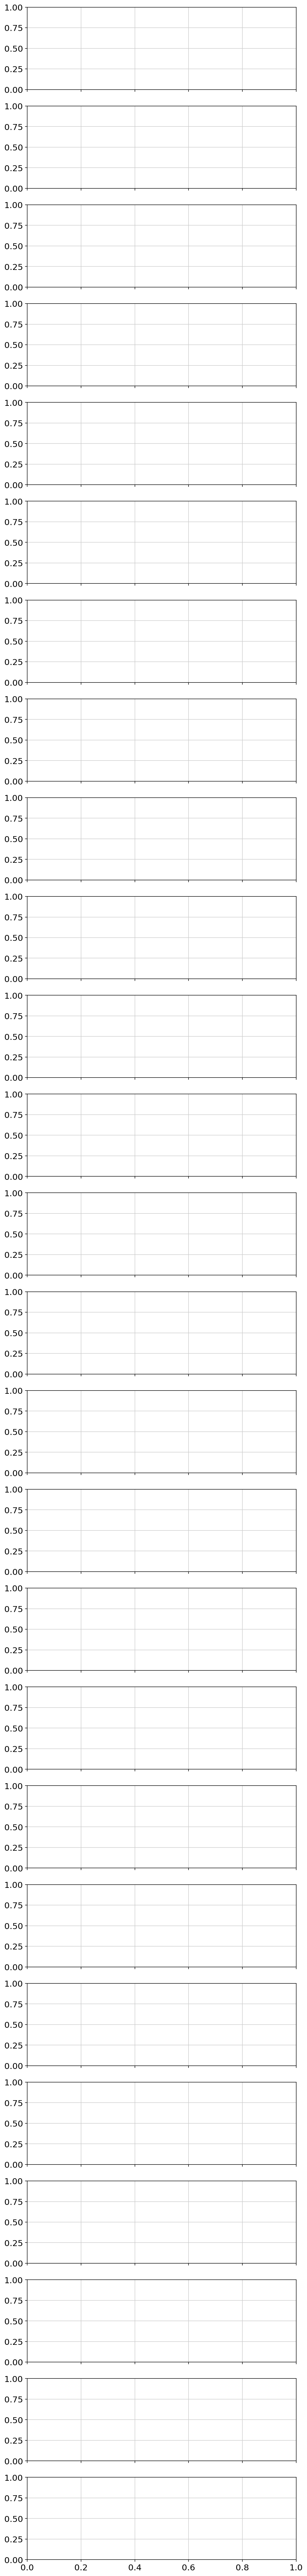

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import pickle

df = adata_exp.obs.copy()
# Number of permutations
N_PERMUTATIONS = 10000

# Filter for important cells
df_filtered = df[df["importance_hard"] == "True"]

# Compute counts and proportions
count_table = df_filtered.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
prop_table = count_table.div(count_table.sum(axis=1), axis=0)  # Normalize to proportions

# Function for permutation test
def permutation_test(cluster1, cluster2, cell_type, df, n_permutations=N_PERMUTATIONS):
    # Get observed proportion difference
    observed_diff = abs(prop_table.loc[cluster1, cell_type] - prop_table.loc[cluster2, cell_type])

    # Generate null distribution
    null_diffs = []
    for _ in range(n_permutations):
        shuffled_df = df.copy()
        
        # Shuffle cell types instead of cluster labels
        shuffled_df["cell_type"] = np.random.permutation(shuffled_df["cell_type"])
        
        # Recalculate proportions with shuffled data
        shuffled_counts = shuffled_df.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
        shuffled_props = shuffled_counts.div(shuffled_counts.sum(axis=1), axis=0)

        # Compute new proportion difference
        if cell_type in shuffled_props.columns:
            null_diffs.append(abs(shuffled_props.loc[cluster1, cell_type] - shuffled_props.loc[cluster2, cell_type]))
        else:
            null_diffs.append(0)  # If the cell type is missing in this permutation, assume 0

    # Compute empirical p-value
    p_value = (np.sum(np.array(null_diffs) >= observed_diff) + 1) / (n_permutations + 1)
    return p_value

# Perform permutation test for all cell types
p_values_all = {}
posthoc_results = {}

for cell_type in prop_table.columns:
    print(cell_type)
    pairwise_p_values = []
    pairwise_comparisons = []

    # Generate pairwise comparisons for all clusters
    for cluster1, cluster2 in combinations(count_table.index, 2):
        p_value = permutation_test(cluster1, cluster2, cell_type, df_filtered, N_PERMUTATIONS)
        pairwise_p_values.append(p_value)
        pairwise_comparisons.append((cluster1, cluster2))

    # Adjust for multiple testing (FDR correction)
    _, p_adjusted, _, _ = multipletests(pairwise_p_values, method="fdr_bh")

    # Store significant results
    posthoc_results[cell_type] = {pair: p for pair, p in zip(pairwise_comparisons, p_adjusted) if p < 0.001}

# Function to convert p-values into asterisks
def pval_to_stars(p):
    if p < 0.0001:
        return "***"
    elif p < 0.001:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


os.makedirs(PLT_PATH, exist_ok=True)

# Plot proportions with significance markers
num_cell_types = len(prop_table.columns)
fig, axes = plt.subplots(nrows=num_cell_types, figsize=(8, num_cell_types * 3), sharex=True)

if num_cell_types == 1:
    axes = [axes]  # Ensure axes is iterable for a single plot

# Generate separate figures for each cell type
for cell_type in prop_table.columns:
    print("Performing statistical analysis for ", cell_type)
    fig, ax = plt.subplots(figsize=(8, 4))

    # Sort clusters by proportion
    sorted_clusters = prop_table[cell_type].sort_values(ascending=False).index
    sorted_props = prop_table.loc[sorted_clusters, cell_type]

    sns.barplot(x=sorted_clusters, y=sorted_props, ax=ax, palette="viridis")
    ax.set_title(f"Proportion of {cell_type} across clusters\n(Permutation test)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Cluster")
    ax.set_ylim(0, 0.2)

    # Add statistical significance markers
    cluster_positions = np.arange(len(sorted_clusters))
    if cell_type in posthoc_results:
        for (cluster1, cluster2), p_val in posthoc_results[cell_type].items():
            if cluster1 in sorted_clusters and cluster2 in sorted_clusters:
                y_max = max(sorted_props[cluster1], sorted_props[cluster2]) + 0.05
                x1, x2 = cluster_positions[sorted_clusters == cluster1][0], cluster_positions[sorted_clusters == cluster2][0]

                # Add line and significance stars
                ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], color="black")
                ax.text((x1 + x2) / 2, y_max + 0.03, pval_to_stars(p_val), ha="center", va="bottom", fontsize=12, color="red")

    # Save each figure separately
    plt.tight_layout()
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.pdf"))
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.png"))
    plt.close(fig)  # Close the figure to avoid memory issues

print("Figures saved successfully.")

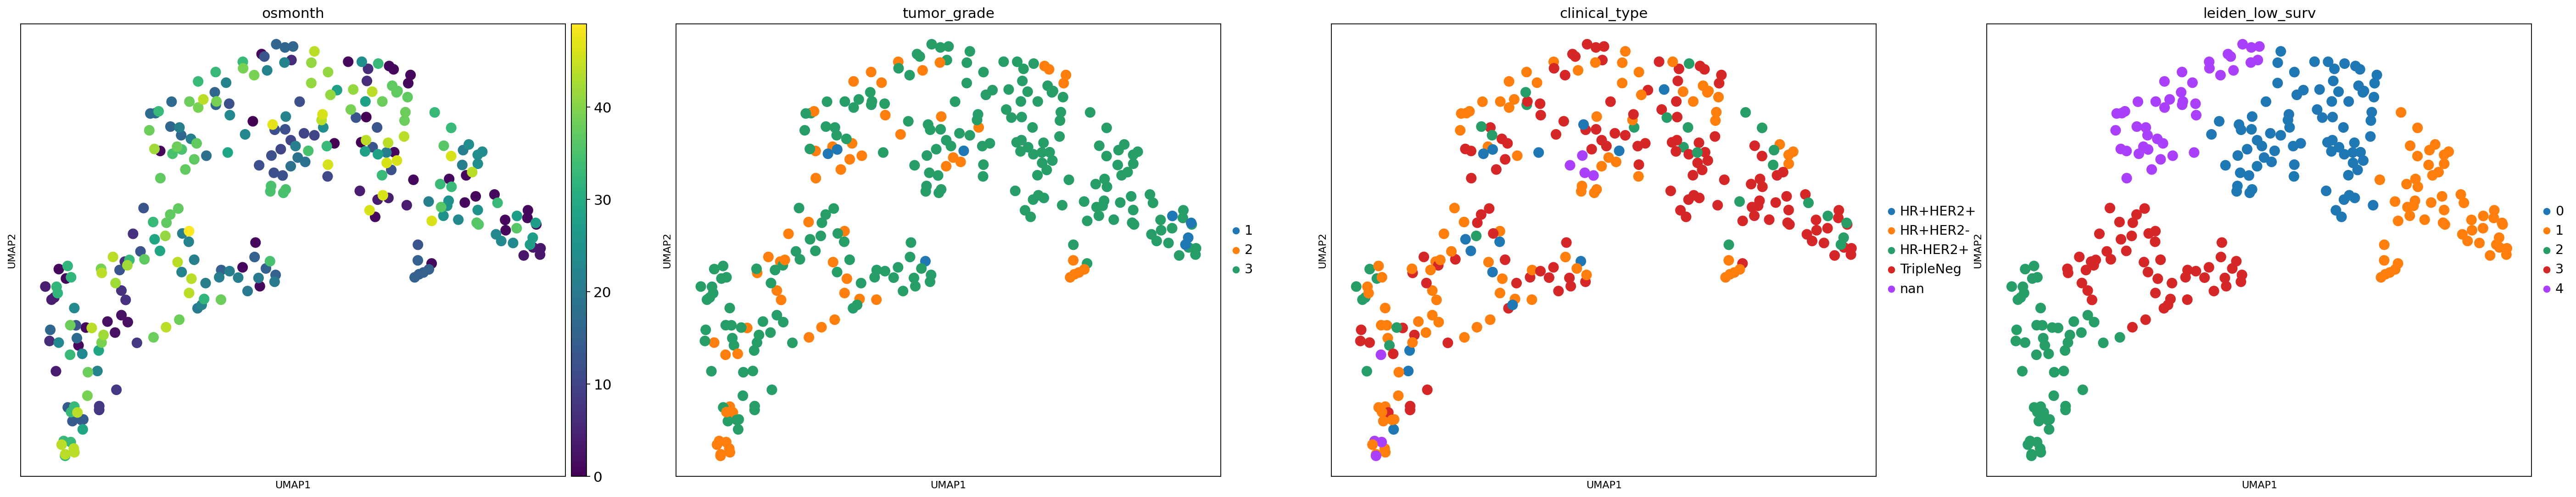

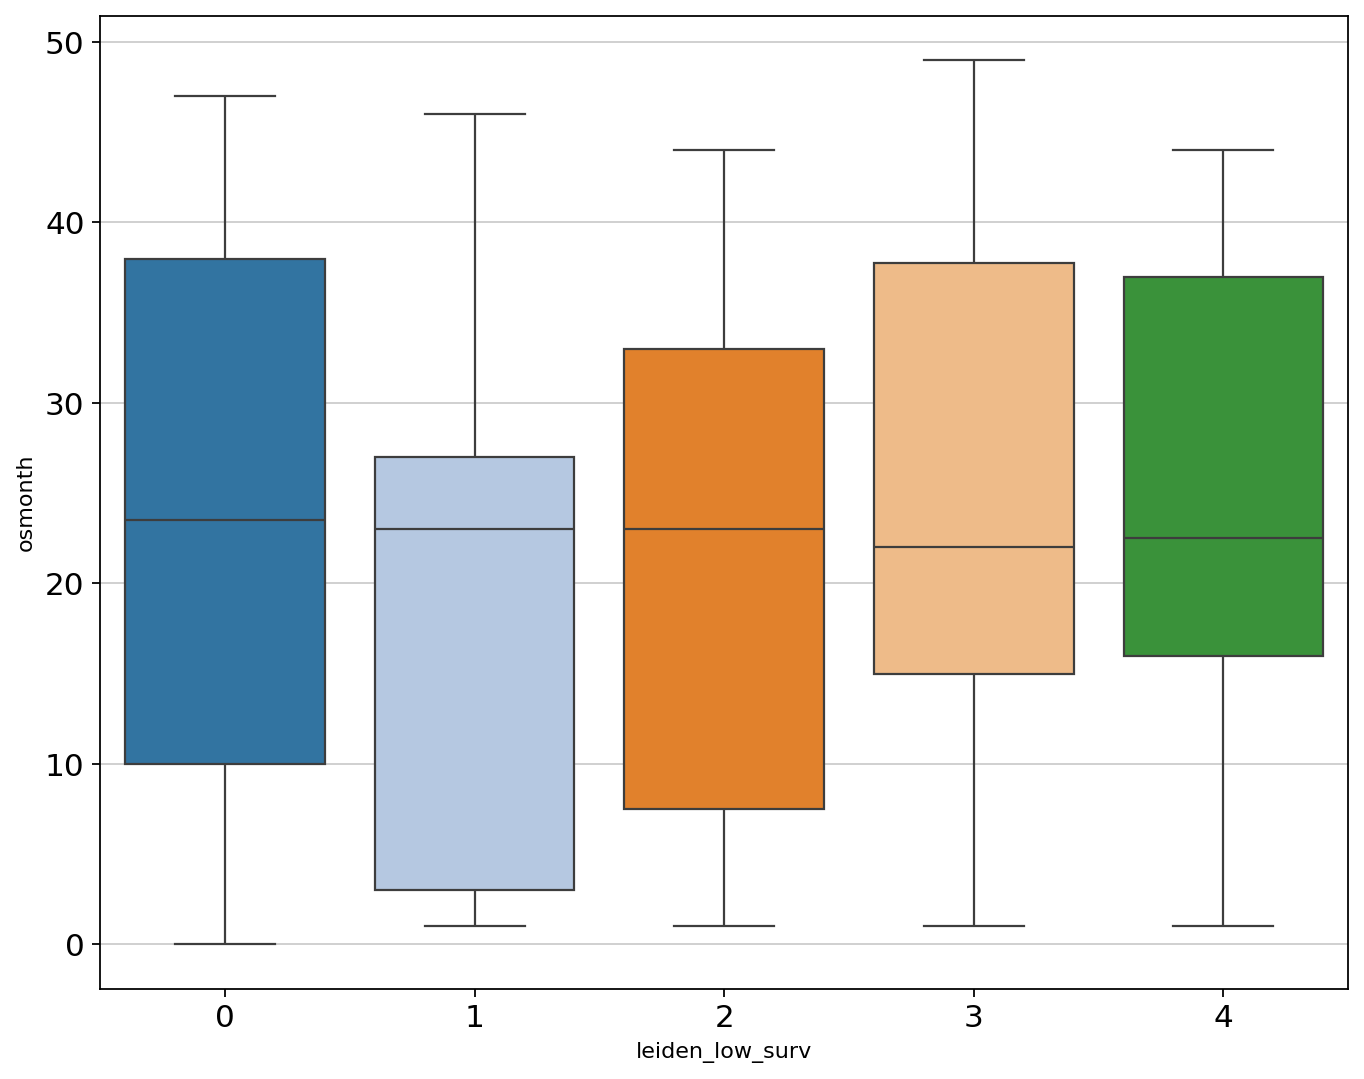

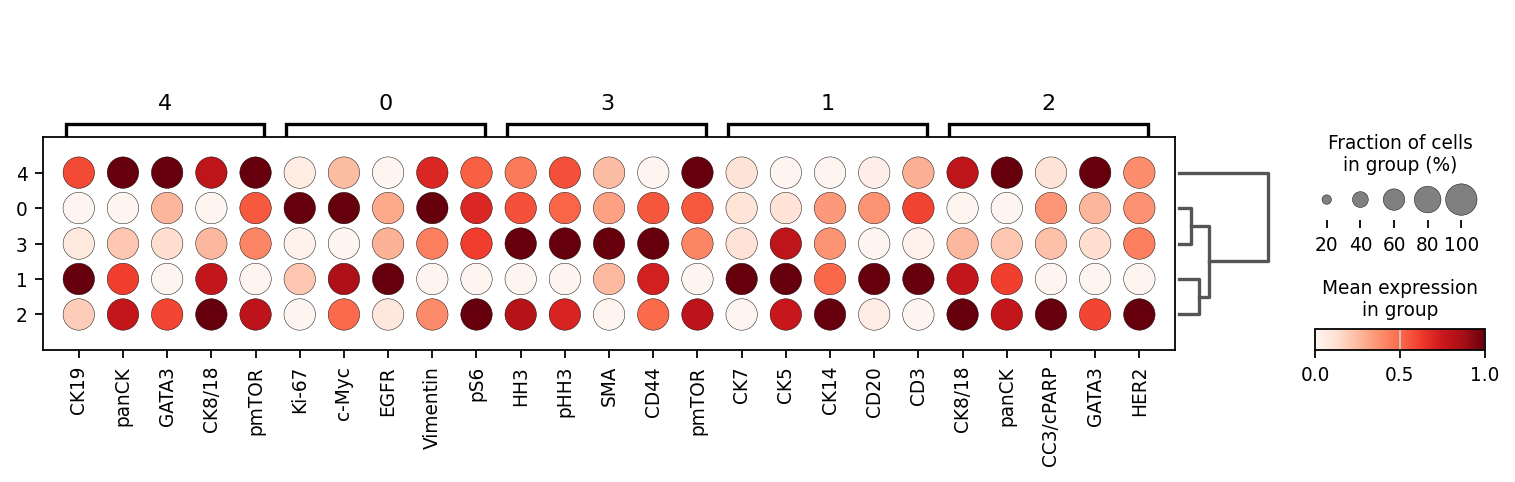

In [19]:
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))
adata_lower = adata_emb[adata_emb.obs["osmonth"]<lower_quartile,:].copy()

sc.tl.pca(adata_lower, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_lower)
sc.tl.umap(adata_lower)

sc.tl.leiden(adata_lower, resolution=0.3, key_added = "leiden_low_surv")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_lower, show=False, color=["osmonth", "tumor_grade", "clinical_type", "leiden_low_surv"])
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_lowsurv_embedding_umap.pdf"), dpi=300)
sc.pl.umap(adata_lower, show=False, color="leiden_low_surv", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_lowsurv_embedding_clust_umap.pdf"), dpi=300)
plt.clf()
sns.boxplot(data=adata_lower.obs, x="leiden_low_surv", y="osmonth", showfliers = False, palette= color_dict)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_lowsurv_embedding_boxplot.pdf"), dpi=300)
# sc.pl.violin(adata_lower, 'osmonth', groupby='leiden', palette=color_dict)

pdata_imp_low = pdata_imp[pdata_imp.obs_names.isin(adata_lower.obs_names),:].copy()

pdata_imp_low.obs["leiden_low_surv"] = adata_lower.obs["leiden_low_surv"]
pdata_imp_low.obsm["X_umap"] = adata_lower.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_imp_low, groupby=f"leiden_low_surv", method='wilcoxon', key_added = f"wilcoxon_low")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp_low, n_genes=5, standard_scale='var', key=f"wilcoxon_low", show=False, groupby="leiden_low_surv")
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_lowsurv_dotplot.pdf"), dpi=300)


38


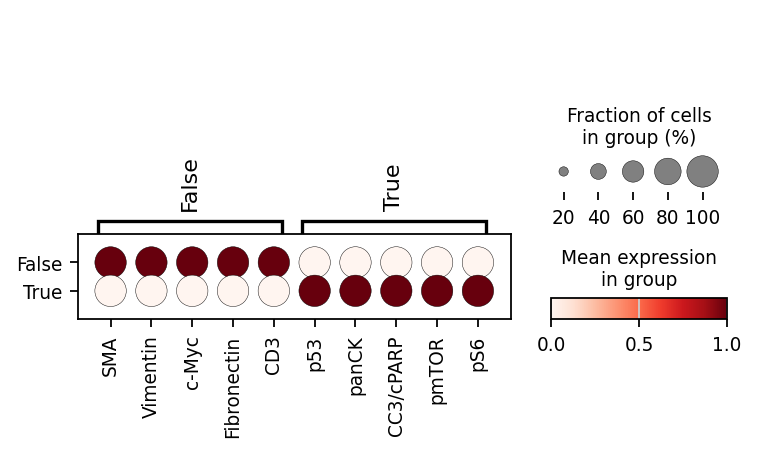

In [20]:
# pdata_imp_vs_unimp.obs

lower_quartile = int(np.quantile(pdata_imp_vs_unimp.obs["osmonth"], 0.20))
print(lower_quartile)
pdata_lower = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs["osmonth"]<lower_quartile,:].copy()
with plt.rc_context():
    sc.tl.rank_genes_groups(pdata_lower, groupby=f"importance_hard", method='wilcoxon', key_added = f"wilcoxon_importance_hard")
    sc.pl.rank_genes_groups_dotplot(pdata_lower, n_genes=5, standard_scale='var', key=f"wilcoxon_importance_hard", show=False, groupby="importance_hard")
    plt.tight_layout()
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_vs_unimp_dotplot.pdf"), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_vs_unimp_dotplot.png"), dpi=300, bbox_inches='tight')


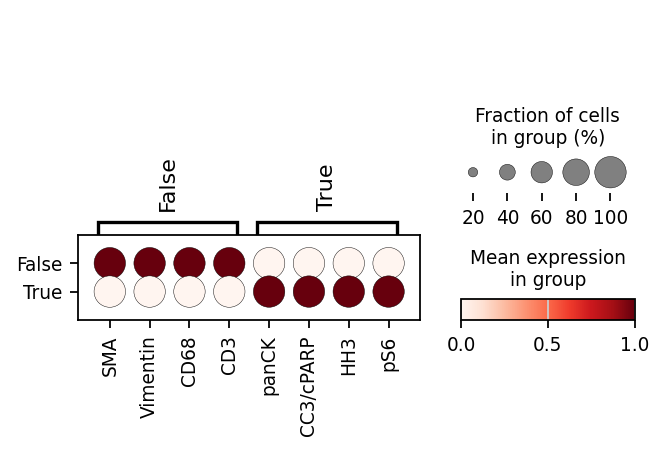

<Figure size 800x640 with 0 Axes>

In [21]:
with plt.rc_context():
    sc.tl.rank_genes_groups(pdata_imp_vs_unimp, groupby=f"importance_hard", method='wilcoxon', key_added = f"wilcoxon_importance_hard_all")
    sc.pl.rank_genes_groups_dotplot(pdata_imp_vs_unimp, n_genes=4, standard_scale='var', key=f"wilcoxon_importance_hard_all", show=True, groupby="importance_hard")
    plt.tight_layout()

In [22]:
pdata_lower.obs["importance_hard"]

114ll_False    False
114lr_False    False
114ul_False    False
114ur_False    False
115ll_False    False
               ...  
76ur_True       True
99ll_True       True
99lr_True       True
99ul_True       True
99ur_True       True
Name: importance_hard, Length: 438, dtype: category
Categories (2, object): ['False', 'True']

<h1>Clinical Subtype Analysis - Low vs. High Survivors</h1>

In [23]:
clinical_type = "HR+HER2-"
adata_emb_clinical_subtype = adata_emb[adata_emb.obs["clinical_type"]==clinical_type,:].copy()
upper_quartile = int(np.quantile(adata_emb_clinical_subtype.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb_clinical_subtype.obs["osmonth"], 0.25))

adata_emb_clinical_subtype.obs["high_surv"]="0"
adata_emb_clinical_subtype.obs["low_surv"]="0"

adata_emb_clinical_subtype.obs.loc[adata_emb_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb_clinical_subtype.obs.loc[adata_emb_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"

<Figure size 2568x800 with 0 Axes>

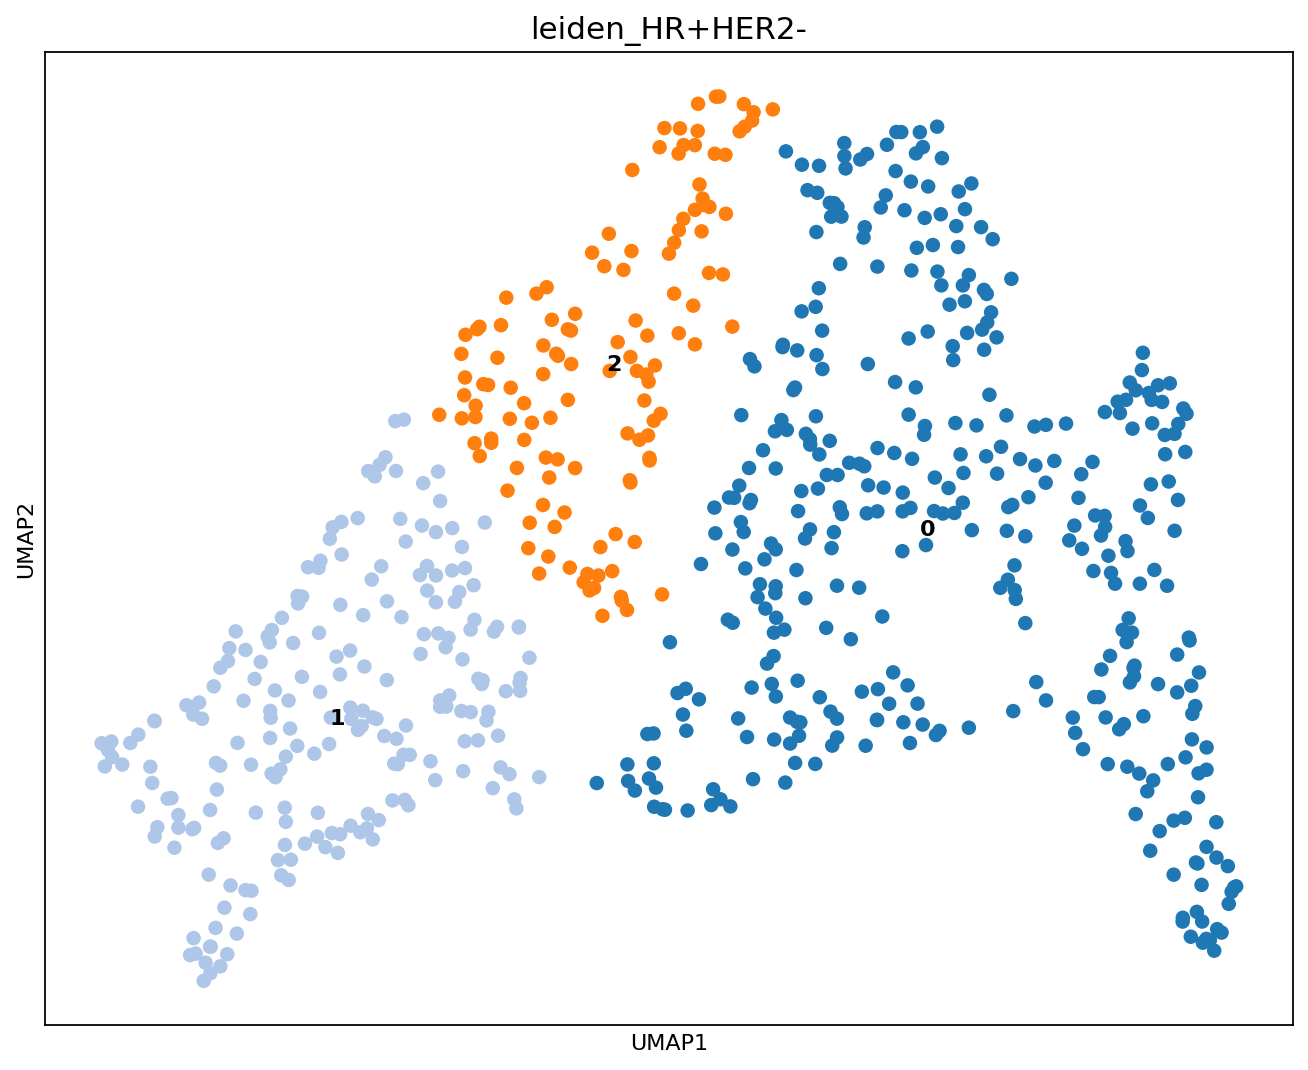

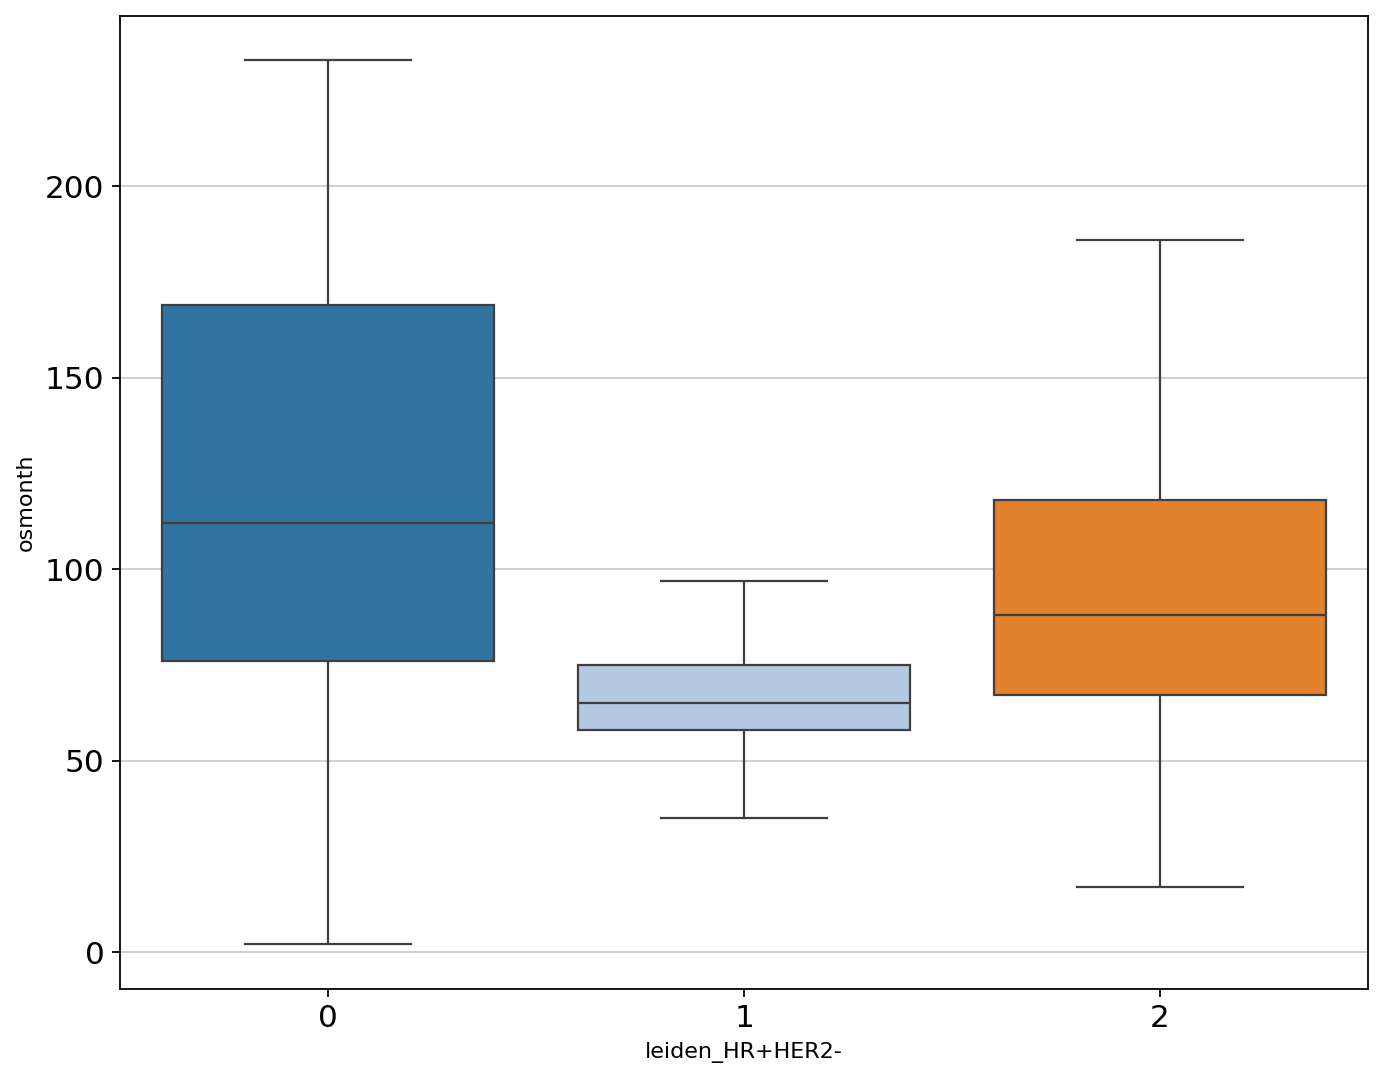

In [24]:
sc.tl.pca(adata_emb_clinical_subtype, svd_solver='arpack', random_state=42)
sc.pp.neighbors(adata_emb_clinical_subtype)
sc.tl.umap(adata_emb_clinical_subtype)

sc.tl.leiden(adata_emb_clinical_subtype, resolution=0.1, key_added = f"leiden_{clinical_type}")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

"""old_to_new = dict(
    old_cluster1='new_cluster1',
    old_cluster2='new_cluster1',
    old_cluster3='new_cluster2',
)
adata.obs['new_clusters'] = (
    adata.obs['old_clusters']
    .map(old_to_new)
    .astype('category')
)"""
adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"][adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].isin(["0", "3"])]="0"
adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.remove_categories(["3"])
adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.rename_categories(np.arange(len(np.unique(adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"]))).astype('str'))

for ind, clust_index in enumerate(adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]
rcParams['figure.figsize']=(15,10)
sc.pl.umap(adata_emb_clinical_subtype, size=500, show=False, color=["osmonth",f"leiden_{clinical_type}"]) #  "tumor_grade", "clinical_type"
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_umap.pdf"), dpi=300)
plt.clf()
rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb_clinical_subtype, color=f"leiden_{clinical_type}", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_clust_umap.pdf"), dpi=300)
plt.clf()
sns.boxplot(data=adata_emb_clinical_subtype.obs, x=f"leiden_{clinical_type}", y="osmonth", showfliers = False, palette= color_dict)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_boxplot.pdf"), dpi=300)

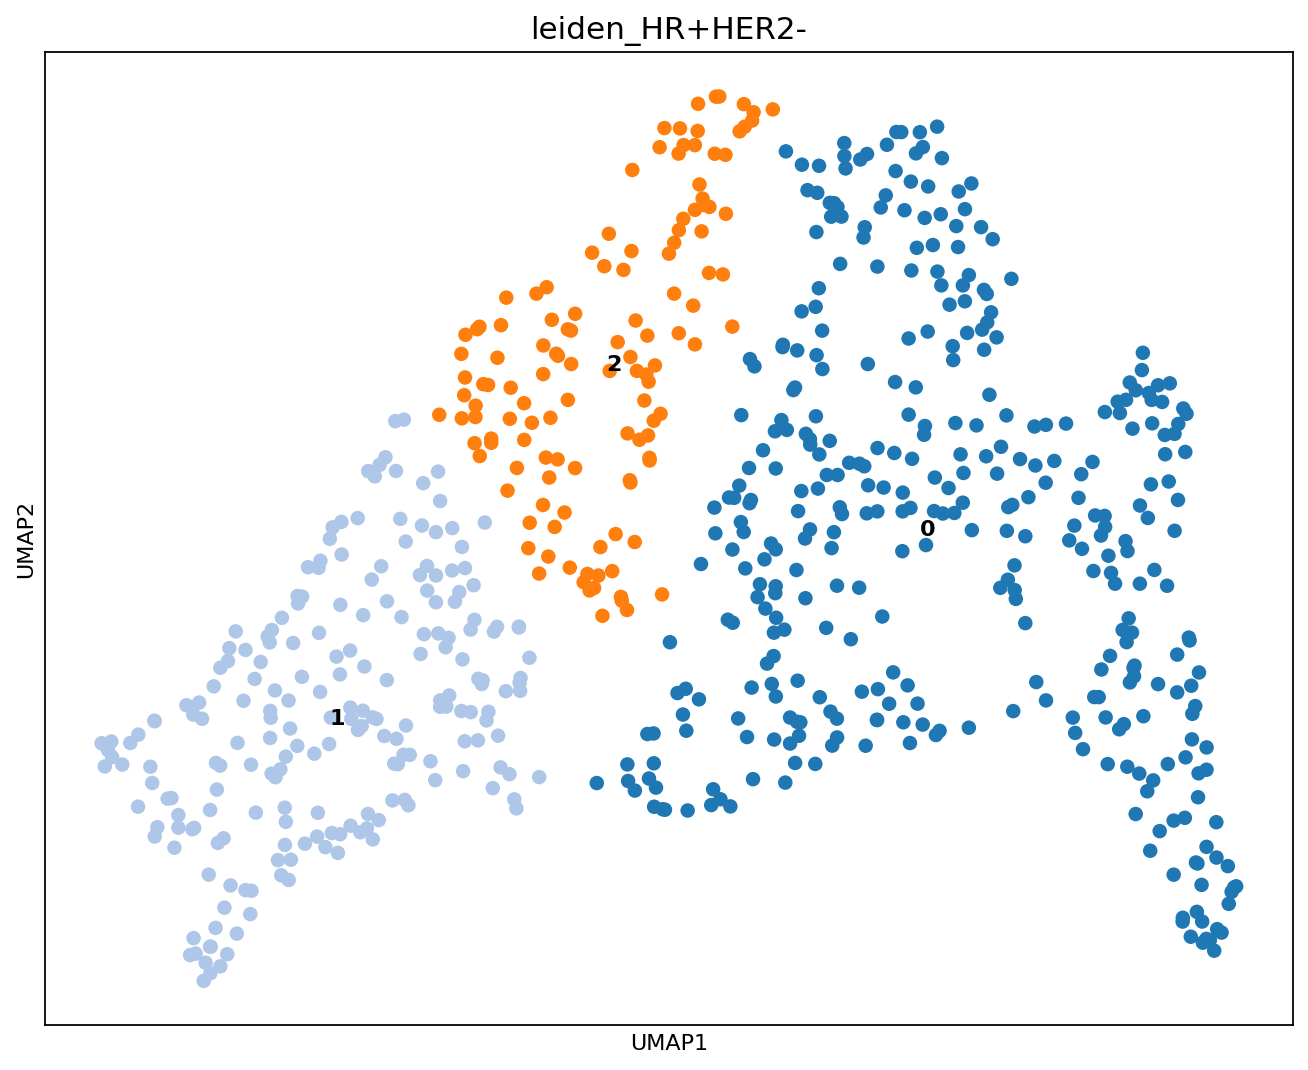

<Figure size 800x640 with 0 Axes>

In [25]:
sc.pl.umap(adata_emb_clinical_subtype, color=f"leiden_{clinical_type}", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_clust_umap.pdf"), dpi=300)
plt.clf()

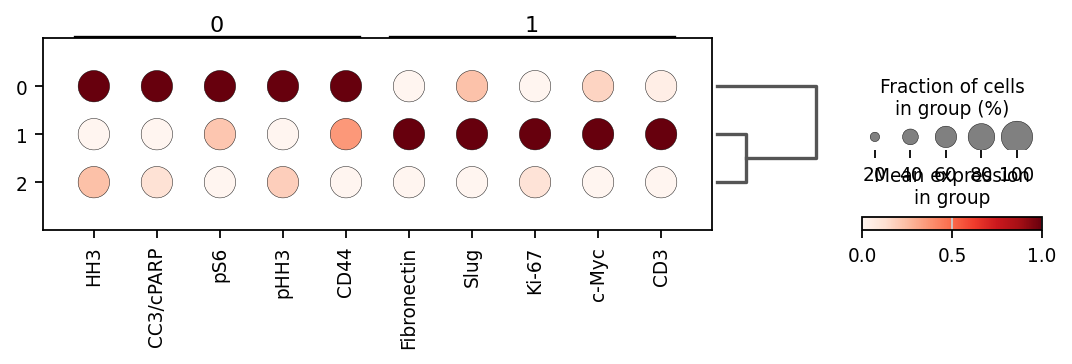

In [26]:
pdata_clinical_subtype = pdata_imp[pdata_imp.obs_names.isin(adata_emb_clinical_subtype.obs_names),:].copy()

pdata_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"]
pdata_clinical_subtype.obsm["X_umap"] = adata_emb_clinical_subtype.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_clinical_subtype, groupby=f"leiden_{clinical_type}", sharey=False, method='wilcoxon', groups=["0", "1"], key_added = f"wilcoxon_{clinical_type}")
# sc.tl.rank_genes_groups(pdata_clinical_subtype, groupby=f"leiden_{clinical_type}", sharey=False, method='wilcoxon', key_added = f"wilcoxon_{clinical_type}")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_clinical_subtype, n_genes=5, standard_scale='var', key=f"wilcoxon_{clinical_type}",  figsize = (8,12),  show=False, groupby=f"leiden_{clinical_type}")
plt.tight_layout()
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_{clinical_type}_dotplot.pdf"), dpi=300)
